In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

C:\Users\Aleksey\Anaconda3\lib\site-packages\pytz\__init__.py:29: UserWarning: Module concurrent was already imported from C:\Users\Aleksey\Anaconda3\lib\concurrent\__init__.py, but c:\users\aleksey\appdata\roaming\python\python35\site-packages\futures-3.1.1-py3.5.egg is being added to sys.path
  from pkg_resources import resource_stream


**Load both datasets**

In [70]:
ds2, ds1 = pd.read_csv('ds-boot-1.csv', sep='\t'), pd.read_csv('ds-boot-2.csv', sep='\t')

### Part 1.1

In [71]:
train, target = ds1.iloc[:, 1:29], ds1.iloc[:, 29:]

In [72]:
# part 1.1: estimate stats using bootstrap
def est_stats(sample, n_resamples=100):
    # bootstrap sample size
    b_sample_size = sample.shape[0]
    
    # boostrap resamples
    b_resamples = np.ndarray((n_resamples, b_sample_size))
    
    for i in range(0, n_resamples):
        b_resamples[i] = resample(sample, n_samples=b_sample_size)
    
    b_resamples_means = [rs.mean() for rs in b_resamples]
    
    return pd.DataFrame(b_resamples_means)
    

In [73]:
# part 1.1: estimate stats using bootstrap for each y_i
for y_i in target:
    sample = target[y_i]
    
    print(y_i, est_stats(sample).describe())

y1                 0
count  100.000000
mean     4.065750
std      0.537829
min      2.862500
25%      3.725000
50%      4.031250
75%      4.431250
max      6.337500
y2                 0
count  100.000000
mean     5.489312
std      0.549208
min      4.356250
25%      5.028125
50%      5.468750
75%      5.803125
max      6.987500
y3                 0
count  100.000000
mean     7.222965
std      0.494212
min      5.995000
25%      6.853937
50%      7.200500
75%      7.577312
max      8.344250
y4                 0
count  100.000000
mean     1.516270
std      0.108606
min      1.245750
25%      1.441500
50%      1.517250
75%      1.587125
max      1.793250
y5                 0
count  100.000000
mean     5.574935
std      0.482968
min      4.373500
25%      5.276000
50%      5.549000
75%      5.934750
max      6.768500


### Part 1.2

In [82]:
from sklearn.metrics import r2_score

# part 1.2: est coefficients for LR
def est_lr_coeffs(train, y, n_resamples=10):
    sample_size = y.shape[0]
    
    lr = LinearRegression()    
    
    resamples = np.ndarray((n_resamples, sample_size))
    bootstrap_coeffs = np.ndarray((n_resamples, train.shape[1] + 1))
    det_coeffs = np.ndarray((n_resamples, ))
    
    # find coefficients for original y sample
    lr.fit(train, y)
    origin_coeffs = np.concatenate((lr.coef_, [lr.intercept_]))
    
    # resampling and finding coefficients of LR for each resample
    for j in range(n_resamples):
        resamples[j] = resample(y, n_samples=sample_size)
        
        lr.fit(train, resamples[j])
        
        y_predicted = lr.predict(train)
        
        det_coeffs[j] = r2_score(y, y_predicted)
        bootstrap_coeffs[j] = np.concatenate((lr.coef_, [lr.intercept_]))
    
    # find 95-% confidence interval 
    deltas = origin_coeffs - bootstrap_coeffs
    deltas_l = np.percentile(deltas, 2.5, axis=0)
    deltas_r = np.percentile(deltas, 97.5, axis=0)
    
    l_bound = origin_coeffs - deltas_r
    upp_bound = origin_coeffs - deltas_l
    
    return pd.DataFrame([{'est': origin_coeffs[i],
                          'low_bound': l_bound[i],
                          'upp_bound': upp_bound[i]
                         } 
                         for i in range(train.shape[1])])
    
    # sort bootstrap samples according to coefficient of determination of LR
#     sorted_samples = np.ndarray((n_resamples, sample_size))
#     for i, t in enumerate(sorted(zip(det_coeffs, resamples), key=lambda e: e[0], reverse=True)):
#         det_coeff, sample = t
#         sorted_samples[i] = sample
    
#     return sorted_samples

In [83]:
# part 1.2: estimate coefficients for LR for each y_i
for y_i in target:
    target_i = target[y_i]
    
    print('\n', y_i, '\n', est_lr_coeffs(train, target_i, n_resamples=1000))


 y1 
          est  low_bound  upp_bound
0   0.352388  -0.786960   0.781436
1  -0.087259  -0.743695   0.748361
2  -0.472046  -1.358899   1.314174
3   1.121283  -1.225417   1.090956
4  -0.325610  -0.961106   0.975646
5   0.916609  -1.593026   1.589221
6  -1.070163  -1.369522   1.450655
7  -0.210380  -1.042294   1.051247
8  -0.184591  -1.284114   1.247275
9  -0.342690  -1.256194   1.207878
10  0.764015  -1.289208   1.276828
11  0.040134  -1.588204   1.559167
12  0.219712  -1.157727   1.067554
13 -0.132371  -0.795164   0.760816
14 -0.801004  -0.839442   0.848603
15  0.255596  -0.479605   0.440370
16  0.577988  -0.779427   0.817732
17 -0.121128  -0.638353   0.586182
18 -0.418202  -0.801956   0.821265
19 -0.259606  -0.762434   0.804258
20  0.793505  -0.780522   0.810019
21 -0.113371  -0.677274   0.675761
22  0.410392  -0.581285   0.581673
23 -0.382840  -0.763276   0.821058
24  0.603136  -1.103975   1.122082
25  0.136971  -0.835933   0.819634
26 -0.397624  -0.883005   0.853228
27 -0.103562 

### Part 2

In [84]:
ds2.head(5)

,day,bugsPerDay,cummBugs
0,1,0,0
1,2,1,1
2,3,0,1
3,4,2,3
4,5,1,4


In [85]:
train, target = np.array(ds2.day), np.array(ds2.cummBugs)

In [86]:
def predict_y(a, b, x):
    return a * (1 - (1 + b * x) * np.exp(-b * x))

In [87]:
from scipy.optimize import minimize

def find_best_coeffs(X, Y):
    loss = lambda coeffs: np.mean((predict_y(coeffs[0], coeffs[1], X) - Y) ** 2)
    
    return minimize(loss, [5000., 0.001], tol=1e-25).x

In [88]:
coefs = find_best_coeffs(train, target)
print('Coeffs with the minimum loss function:', coefs)

Coeffs with the minimum loss function: [  8.54128298e+03   1.85848366e-03]


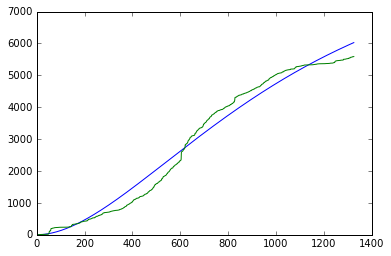

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(predict_y(coefs[0], coefs[1], train))
plt.plot(target)

In [93]:
from tqdm import tqdm

exp_len = 900

B = 500
bs_coefs = []

samples_count = len(ds2)

for _ in range(B):
    samp_len = min(samples_count - 1, np.random.geometric(1.0 / (exp_len + 1.0)))
    
    start_ind = np.random.randint(0, samples_count - samp_len)
    samp_ind = np.array(range(start_ind, start_ind + samp_len))
    
    x_bs = train[samp_ind]
    y_bs = target[samp_ind]
    
    bs_coefs.append(find_best_coeffs(x_bs, y_bs))

bs_coefs = np.array(bs_coefs)

C:\Users\Aleksey\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\Aleksey\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app
C:\Users\Aleksey\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: overflow encountered in square
C:\Users\Aleksey\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Users\Aleksey\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\Aleksey\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app
C:\Users\Aleksey\Anaconda3\lib\site-packages\ipykernel\__main__.py:

In [94]:
deltas = coefs - bs_coefs

deltas_l = np.percentile(deltas, 2.5, axis=0)
deltas_r = np.percentile(deltas, 97.5, axis=0)

l_bound = coefs - deltas_r
r_bound = coefs - deltas_l

In [95]:
print('Estimation of model parameters')
pd.DataFrame([{'est': coefs[i],
               'low_bound': l_bound[i],
               'upp_bound': r_bound[i]} for i in range(2)])

Estimation of model parameters


,est,low_bound,upp_bound
0,8541.282980,1132.666598,2.005079e+06
1,0.001858,0.000083,1.012387e+00
